In [1]:
#!pip install "httplib2 == 0.20.2"
# in AttributeError: module 'tensorflow' has no attribute 'gfile' --> tf.io.gfile
# numpy >= 1.16.5
# AttributeError: module 'tensorflow._api.v2.io.gfile' has no attribute 'Exists' -- > 'exists'
# AttributeError: module 'tensorflow._api.v2.io.gfile' has no attribute 'MakeDirs' --> 'makedirs'
# numpy >= 1.17 for matplotlib --> numpy 1.19.4
import load_data

from sklearn import svm
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn import metrics
import pickle
import time
from sklearn.utils import shuffle

In [2]:
# return DataSet class
data = load_data.read_data_sets(one_hot=False)

#BATCH_SIZE = 15
# get train data and labels by batch size
#train_x, train_label = data.train.next_batch(BATCH_SIZE)

# get train data
train_x = data.train.data

# get train labels
train_labels = data.train.labels

# get test data
test_x = data.test.data

# get test labels
test_labels = data.test.labels

# get sample number
n_samples = data.train.num_examples

In [3]:
print(train_x.shape, train_labels.shape)

((84420, 310), (84420,))

In [4]:
print(test_x.shape, test_labels.shape)

((58128, 310), (58128,))

In [5]:
print(np.unique(train_labels, return_counts = True))

(array([0, 1, 2], dtype=int16), array([28602, 26628, 29190], dtype=int64))

In [6]:
print(np.unique(test_labels, return_counts = True))

(array([0, 1, 2], dtype=int16), array([18438, 19740, 19950], dtype=int64))

In [7]:
# Shuffle the data
train_x, train_labels = shuffle(train_x, train_labels, random_state=42)

# Data Augmentation

In [8]:
from skimage.util import random_noise
from sklearn.preprocessing import scale

In [9]:
start_time = time.time()

# Add random noise to DE values
# augmented_data = random_noise(principalComponents, mode='gaussian', mean=0, var=0.01)

# Scale DE values by a random factor
# augmented_data = principalComponents * np.random.uniform(0.5, 1.5, size=principalComponents.shape)
# Standardize the scaled DE values
# augmented_data = scale(augmented_data)

# Add a random offset to the DE values
# augmented_data = train_x + np.random.normal(0, 0.1, size=train_x.shape)

# Determine the class with the largest number of samples
class_counts = np.bincount(train_labels)
print(class_counts)
largest_class_count = np.max(class_counts)
print(largest_class_count)

# Calculate the number of new samples to generate for each class
new_sample_counts = [largest_class_count - count for count in class_counts]

# For each class, randomly sample with replacement from its samples to create new samples
for i in range(len(new_sample_counts)):
    if new_sample_counts[i] > 0:
        new_samples = np.random.choice(np.where(train_labels == i)[0], size=new_sample_counts[i], replace=True)
        train_x = np.concatenate((train_x, train_x[new_samples]), axis=0)
        train_labels = np.concatenate((train_labels, np.full((new_sample_counts[i],), i)), axis=0)

seconds = time.time() - start_time
print('Total Time Taken for data augmentation:', time.strftime("%H:%M:%S",time.gmtime(seconds)))

[28602 26628 29190]
29190
Total Time Taken for data augmentation: 00:00:00


In [10]:
print(np.unique(train_labels, return_counts = True))

(array([0, 1, 2]), array([29190, 29190, 29190], dtype=int64))

# PCA / Feature extraction

In [11]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import pandas as pd

In [13]:
train_x = StandardScaler().fit_transform(train_x)
test_x = StandardScaler().fit_transform(test_x)

In [14]:
start_time = time.time()

In [15]:
from sklearn.decomposition import PCA
pca = PCA(n_components = 145)
principalComponents = pca.fit_transform(train_x)
test_principalComponents = pca.transform(test_x)
seconds = time.time() - start_time
print('Total Time Taken for PCA:', time.strftime("%H:%M:%S",time.gmtime(seconds)))

Total Time Taken for PCA: 00:00:15


# Training the SVM Model

In [16]:
start_time = time.time()
poly = svm.SVC(kernel='poly', degree=3, C=1, decision_function_shape='ovo').fit(principalComponents, train_labels)
seconds = time.time() - start_time
print('Total Time Taken for model training:', time.strftime("%H:%M:%S",time.gmtime(seconds)))

Total Time Taken for model training: 00:09:11


# Testing the model

In [17]:
poly_prediction = poly.predict(test_principalComponents)

In [18]:
accuracy_poly = poly.score(test_principalComponents, test_labels)

In [19]:
print(f'Testing accuracy: {accuracy_poly}')

Testing accuracy: 0.7855250481695568


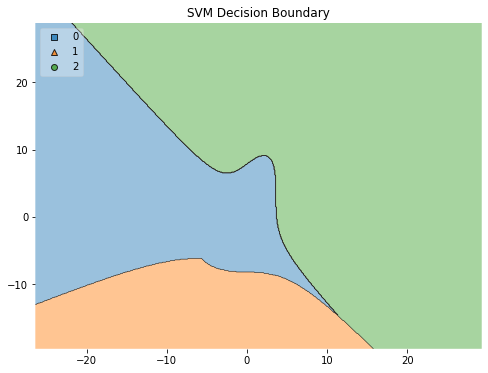

In [26]:
from mlxtend.plotting import plot_decision_regions
feature_values = {i:np.mean(principalComponents[:, i]) for i in range(2, 145)} 
feature_width = {i:1 for i in range(2, 145)}  
plt.figure(figsize=(8, 6))
plot_decision_regions(principalComponents, train_labels, poly, legend=2, filler_feature_values=feature_values,
                      filler_feature_ranges=feature_width)
plt.title("SVM Decision Boundary")
plt.show()